In [1]:
# Import all the required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import re
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
# Import the random forest classifier - This is a classification problem and I think this is the best model for prediction
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import compose

In [3]:
catg_feature_names = [
    'funder',
    'basin',
    'region',                    
    'district_code',
    'lga',
    'scheme_management',
    'extraction_type',
    'extraction_type_class',
    'management',
    'payment_type',
    'water_quality',
    'quantity',
    'source',     
    'source_class',
#    'waterpoint_type_group'
]

num_feature_names = [
#    'amount_tsh',
#    'gps_height',
    'longitude',
    'latitude',
#    'population',
    'construction_year',
    'pump_age'
]

date_feature_names = [
#    'date_recorded',
    'year_rec',
    'week_rec',
    'day_rec'
]

label_names = ['status_group']

In [4]:
# Load the cleaned dataset and view the first few rows
df = pd.read_csv('data/cleaned_df_v2.csv', usecols= ['date_recorded'] + catg_feature_names + num_feature_names + label_names)
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date_recorded          59400 non-null  datetime64[ns]
 1   funder                 59400 non-null  object        
 2   longitude              59400 non-null  float64       
 3   latitude               59400 non-null  float64       
 4   basin                  59400 non-null  object        
 5   region                 59400 non-null  object        
 6   district_code          59400 non-null  int64         
 7   lga                    59400 non-null  object        
 8   scheme_management      59400 non-null  object        
 9   construction_year      59400 non-null  float64       
 10  extraction_type        59400 non-null  object        
 11  extraction_type_class  59400 non-null  object        
 12  management             59400 non-null  object        
 13  p

In [5]:
# Adding date features...
df['year_rec'] = df['date_recorded'].apply(lambda x: pd.to_datetime(x).date().isocalendar()[0])
df['week_rec'] = df['date_recorded'].apply(lambda x: pd.to_datetime(x).date().isocalendar()[1])
df['day_rec'] = df['date_recorded'].apply(lambda x: pd.to_datetime(x).date().isocalendar()[2])
df.drop('date_recorded', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 59400 non-null  object 
 1   longitude              59400 non-null  float64
 2   latitude               59400 non-null  float64
 3   basin                  59400 non-null  object 
 4   region                 59400 non-null  object 
 5   district_code          59400 non-null  int64  
 6   lga                    59400 non-null  object 
 7   scheme_management      59400 non-null  object 
 8   construction_year      59400 non-null  float64
 9   extraction_type        59400 non-null  object 
 10  extraction_type_class  59400 non-null  object 
 11  management             59400 non-null  object 
 12  payment_type           59400 non-null  object 
 13  water_quality          59400 non-null  object 
 14  quantity               59400 non-null  object 
 15  so

In [6]:
# Transform and combine categorical and numerical features:
catg_transformer = compose.ColumnTransformer(
    transformers=
    [
     ('catg', preprocessing.OneHotEncoder(), catg_feature_names),
    ],
    remainder='drop',
    sparse_threshold=0.0,
    n_jobs=None,
    transformer_weights=None,
    #verbose=False
).fit(df.loc[:,catg_feature_names])

In [7]:
def get_name_and_levels(onehot_encoder: compose.ColumnTransformer , catg_names):
    """
    Gets 'transformed catg feature' names from compose.ColumnTransformer object and catg feature names.

    """
    onehot_feature_names = onehot_encoder.get_feature_names()

    f_name_and_level = [catg_names[int(re.search(r'\d+', elm).group())]
                        + '-' + elm.split('__', 1)[-1].split('_', 1)[-1]
                        for elm in onehot_feature_names
                        ]
    return f_name_and_level


catg_features_trans = catg_transformer.transform(df.loc[:, catg_feature_names])
catg_feature_trans_names = get_name_and_levels(catg_transformer, catg_feature_names)
num_features = df.loc[:, num_feature_names]
date_features = df.loc[:, date_feature_names]
# num_feature_trans_names = None

X_trans = np.concatenate([catg_features_trans, num_features, date_features], axis=1)
X_trans_names = catg_feature_trans_names + num_feature_names + date_feature_names
y = df.loc[:,label_names].values

In [8]:
df.loc[:, catg_feature_names]

,funder,basin,region,district_code,lga,scheme_management,extraction_type,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class
0,roman,lake nyasa,iringa,5,ludewa,vwc,gravity,gravity,vwc,annually,soft,enough,spring,groundwater
1,grumeti,lake victoria,mara,2,serengeti,other,gravity,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface
2,lottery club,pangani,manyara,4,simanjiro,vwc,gravity,gravity,vwc,per bucket,soft,enough,dam,surface
3,unicef,ruvuma / southern coast,mtwara,63,nanyumbu,vwc,submersible,submersible,vwc,never pay,soft,dry,machine dbh,groundwater
4,action in a,lake victoria,kagera,1,karagwe,other,gravity,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,germany republi,pangani,kilimanjaro,5,hai,water board,gravity,gravity,water board,per bucket,soft,enough,spring,groundwater
59396,cefa-njombe,rufiji,iringa,4,njombe,vwc,gravity,gravity,vwc,annually,soft,enough,river,surface
59397,other,rufiji,mbeya,7,mbarali,vwc,swn 80,handpump,vwc,monthly,fluoride,enough,machine dbh,groundwater
59398,malec,rufiji,dodoma,4,chamwino,vwc,nira/tanira,handpump,vwc,never pay,soft,insufficient,shallow well,groundwater


In [9]:
# Training Decision Tree Classifier Model
modelDTC = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=15,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight='balanced',
    presort=False)

X_trans_train, X_trans_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.1, random_state=20) # random_state =20

modelDTC.fit(X_trans_train, y_train)
print('trained')
y_pred = modelDTC.predict(X_trans_test)
y_actual = y_test

trained


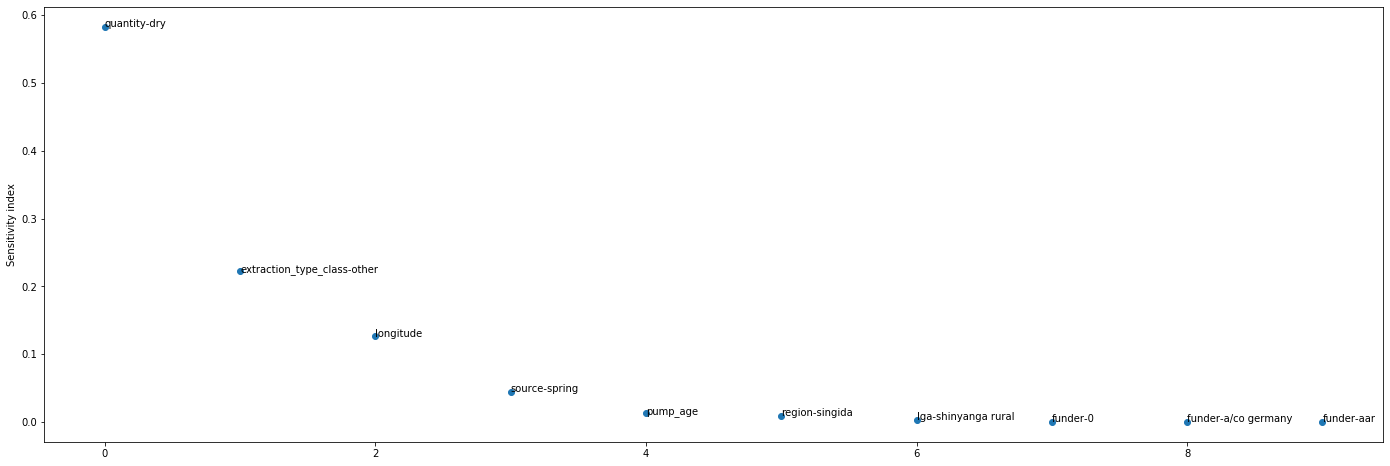

In [10]:
# Plotting most important features
num_top_features = 10
feature_importance = modelDTC.feature_importances_

sorted_f_importance = sorted(zip(X_trans_names, feature_importance),
                             key=lambda x:x[-1],
                             reverse=True)
fig, axe = plt.subplots(1,1)
axe.plot([elm[-1] for elm in sorted_f_importance][:num_top_features], 'o')

for (id, (f_name, f_importance)) in enumerate(sorted_f_importance[:num_top_features]):
    axe.annotate('{}'.format(f_name),xy=(id, f_importance))
axe.set_ylabel('Sensitivity index')
fig = plt.gcf()
fig.set_size_inches(24,8)

In [11]:
y_pred = modelDTC.predict(X_trans_test)
y_actual = y_test

# Performance metric
#perf_metrics = classification_report(y_actual, y_pred, output_dict=True)
model_accurary = modelDTC.score(X_trans_test, y_test)
print('Decision Tree Classifier Accuracy: {}'.format(model_accurary))

Decision Tree Classifier Accuracy: 0.6964646464646465


In [12]:
'''
# Defining X and y columns to use with our models
X = df.drop('status_group', axis=1)
#X.columns
y = df['status_group']

# Using train_test_split to split our dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
'''

"\n# Defining X and y columns to use with our models\nX = df.drop('status_group', axis=1)\n#X.columns\ny = df['status_group']\n\n# Using train_test_split to split our dataset into training and test sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nprint(X_train.shape, X_test.shape)\nprint(y_train.shape, y_test.shape)\n"

In [13]:
modelRFC = RandomForestClassifier(n_estimators=100,min_samples_split=10,criterion='gini')
modelRFC.fit(X_trans_train, y_train)
model_accurary = modelRFC.score(X_trans_test, y_test)
print('RF accuracy: {}'.format(model_accurary))

RF accuracy: 0.8205387205387206


Random Forest 0.8205387205387206
Decision Tree 0.6964646464646465
Extra Trees Classifiers 0.821043771043771


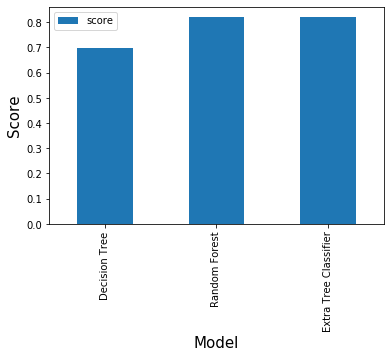

In [23]:
modelETC = ExtraTreesClassifier(n_estimators=100,min_samples_split=10)
modelETC.fit(X_trans_train, y_train)


#modelDTC = DecisionTreeClassifier()
#modelDTC.fit(X_trans_train, y_train)

scoreRFC= modelRFC.score(X_trans_test, y_test)
scoreDTC= modelDTC.score(X_trans_test, y_test)
scoreETC= modelETC.score(X_trans_test, y_test)



print ('Random Forest' ,scoreRFC)
print ('Decision Tree', scoreDTC)
print ('Extra Trees Classifiers', scoreETC)


pd.DataFrame([
    ("Decision Tree", scoreDTC),
    ("Random Forest", scoreRFC),
    ("Extra Tree Classifier", scoreETC),
    ], columns=["Model", "score"]).plot(x="Model", y="score", kind="bar", fontsize=10)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.show()